In [16]:

import argparse,os,pickle,pymp,pynbody,sys,time,warnings, traceback
import numpy as np
from pathlib import Path
import sys

from pynbody import array
from pynbody.analysis import profile
import numpy as np
import logging

#from sphinx.testing.fixtures import shared_result

logger = logging.getLogger('pynbody.analysis.halo')
from numpy import matmul as X
from numpy import sin,cos
from skimage.measure import EllipseModel
from math import pi
import multiprocessing as mp
import pymp




def shape(sim, nbins=100, rmin=None, rmax=None, bins='equal',
          ndim=3, max_iterations=100, tol=1e-3, justify=False):
    """Calculates the shape of the provided particles in homeoidal shells, over a range of nbins radii.

    Homeoidal shells maintain a fixed area (ndim=2) or volume (ndim=3). Note that all provided particles are used in
    calculating the shape, so e.g. to measure dark matter halo shape from a halo with baryons, you should pass
    only the dark matter particles.

    The simulation must be pre-centred, e.g. using :func:`center`.

    The algorithm is sensitive to substructure, which should ideally be removed.

    Caution is advised when assigning large number of bins and radial ranges with many particles, as the
    algorithm becomes very slow.

    Parameters
    ----------

      nbins : int
          The number of homeoidal shells to consider. Shells with few particles will take longer to fit.

      rmin : float
          The minimum radial bin in units of sim['pos']. By default this is taken as rout/1000.
          Note that this applies to axis a, so particles within this radius may still be included within
          homeoidal shells.

      rmax : float
          The maximum radial bin in units of sim['pos']. By default this is taken as the largest radial value
          in the halo particle distribution.

      bins : str
          The spacing scheme for the homeoidal shell bins. 'equal' initialises radial bins with equal numbers
          of particles, with the exception of the final bin which will accomodate remainders. This
          number is not necessarily maintained during fitting. 'log' and 'lin' initialise bins
          with logarithmic and linear radial spacing.

      ndim : int
          The number of dimensions to consider; either 2 or 3 (default). If ndim=2, the shape is calculated
          in the x-y plane. If using ndim=2, you may wish to make a cut in the z direction before
          passing the particles to this routine (e.g. using :class:`pynbody.filt.BandPass`).

      max_iterations : int
          The maximum number of shape calculations (default 10). Fewer iterations will result in a speed-up,
          but with a bias towards spheroidal results.

      tol : float
          Convergence criterion for the shape calculation. Convergence is achieved when the axial ratios have
          a fractional change <=tol between iterations.

      justify : bool
          Align the rotation matrix directions such that they point in a single consistent direction
          aligned with the overall halo shape. This can be useful if working with slerps.

    Returns
    -------

      rbin : SimArray
          The radial bins used for the fitting

      axis_lengths : SimArray
          A nbins x ndim array containing the axis lengths of the ellipsoids in each shell

      num_particles : np.ndarray
          The number of particles within each bin

      rotation_matrices : np.ndarray
          The rotation matrices for each shell

    """

    # Sanitise inputs:
    if (rmax == None): rmax = sim['r'].max()
    if (rmin == None): rmin = rmax / 1E3
    assert ndim in [2, 3]
    assert max_iterations > 0
    assert tol > 0
    assert rmin >= 0
    assert rmax > rmin
    assert nbins > 0
    if ndim == 2:
        assert np.sum((sim['rxy'] >= rmin) & (sim['rxy'] < rmax)) > nbins * 2
    elif ndim == 3:
        assert np.sum((sim['r'] >= rmin) & (sim['r'] < rmax)) > nbins * 2
    if bins not in ['equal', 'log', 'lin']: bins = 'equal'

    # Handy 90 degree rotation matrices:
    Rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
    Ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
    Rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    # -----------------------------FUNCTIONS-----------------------------
    sn = lambda r, N: np.append([r[i * int(len(r) / N):(1 + i) * int(len(r) / N)][0] \
                                 for i in range(N)], r[-1])

    # General equation for an ellipse/ellipsoid:
    def Ellipsoid(pos, a, R):
        x = np.dot(R.T, pos.T)
        return np.sum(np.divide(x.T, a) ** 2, axis=1)

    # Define moment of inertia tensor:
    def MoI(r, m, ndim=3):
        return np.array([[np.sum(m * r[:, i] * r[:, j]) for j in range(ndim)] for i in range(ndim)])

    # Calculate the shape in a single shell:
    def shell_shape(r, pos, mass, a, R, r_range, ndim=3):

        # Find contents of homoeoidal shell:
        mult = r_range / np.mean(a)
        in_shell = (r > min(a) * mult[0]) & (r < max(a) * mult[1])
        pos, mass = pos[in_shell], mass[in_shell]
        inner = Ellipsoid(pos, a * mult[0], R)
        outer = Ellipsoid(pos, a * mult[1], R)
        in_ellipse = (inner > 1) & (outer < 1)
        ellipse_pos, ellipse_mass = pos[in_ellipse], mass[in_ellipse]

        # End if there is no data in range:
        if not len(ellipse_mass):
            return a, R, np.sum(in_ellipse)

        # Calculate shape tensor & diagonalise:
        D = list(np.linalg.eigh(MoI(ellipse_pos, ellipse_mass, ndim) / np.sum(ellipse_mass)))

        # Rescale axis ratios to maintain constant ellipsoidal volume:
        R2 = np.array(D[1])
        a2 = np.sqrt(abs(D[0]) * ndim)
        div = (np.prod(a) / np.prod(a2)) ** (1 / float(ndim))
        a2 *= div

        return a2, R2, np.sum(in_ellipse)

    # Re-align rotation matrix:
    def realign(R, a, ndim):
        if ndim == 3:
            if a[0] > a[1] > a[2] < a[0]:
                pass  # abc
            elif a[0] > a[1] < a[2] < a[0]:
                R = np.dot(R, Rx)  # acb
            elif a[0] < a[1] > a[2] < a[0]:
                R = np.dot(R, Rz)  # bac
            elif a[0] < a[1] > a[2] > a[0]:
                R = np.dot(np.dot(R, Rx), Ry)  # bca
            elif a[0] > a[1] < a[2] > a[0]:
                R = np.dot(np.dot(R, Rx), Rz)  # cab
            elif a[0] < a[1] < a[2] > a[0]:
                R = np.dot(R, Ry)  # cba
        elif ndim == 2:
            if a[0] > a[1]:
                pass  # ab
            elif a[0] < a[1]:
                R = np.dot(R, Rz[:2, :2])  # ba
        return R

    # Calculate the angle between two vectors:
    def angle(a, b):
        return np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

    # Flip x,y,z axes of R2 if they provide a better alignment with R1.
    def flip_axes(R1, R2):
        for i in range(len(R1)):
            if angle(R1[:, i], -R2[:, i]) < angle(R1[:, i], R2[:, i]):
                R2[:, i] *= -1
        return R2

    def process_bin(i, r, pos, mass, rbins, bin_edges, ndim):
        a = np.ones(ndim) * rbins[i]
        R = np.identity(ndim)

        for j in range(max_iterations):
            a2 = a.copy()
            a, R, N = shell_shape(r, pos, mass, a, R, bin_edges[[i, i + 1]], ndim)

            convergence_criterion = np.all(np.isclose(np.sort(a), np.sort(a2), rtol=tol if j < 50 else tol * 5))
            if convergence_criterion:
                R = realign(R, a, ndim)
                if np.sign(np.linalg.det(R)) == -1:
                    R[:, 1] *= -1
                a = np.flip(np.sort(a))
                return i, a, R, N

        return i, np.ones(ndim) * np.nan, np.identity(ndim) * np.nan, 0


    # -----------------------------FUNCTIONS-----------------------------

    # Set up binning:
    r = np.array(sim['r']) if ndim == 3 else np.array(sim['rxy'])
    pos = np.array(sim['pos'])[:, :ndim]
    mass = np.array(sim['mass'])

    if (bins == 'equal'):  # Bins contain equal number of particles
        full_bins = sn(np.sort(r[(r >= rmin) & (r <= rmax)]), nbins * 2)
        bin_edges = full_bins[0:nbins * 2 + 1:2]
        rbins = full_bins[1:nbins * 2 + 1:2]
    elif (bins == 'log'):  # Bins are logarithmically spaced
        bin_edges = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1)
        rbins = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    elif (bins == 'lin'):  # Bins are linearly spaced
        bin_edges = np.linspace(rmin, rmax, nbins + 1)
        rbins = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Initialise the shape arrays:
    rbins = array.SimArray(rbins, sim['pos'].units)
    axis_lengths = array.SimArray(np.zeros([nbins, ndim]), sim['pos'].units) * np.nan
    N_in_bin = np.zeros(nbins).astype('int')
    #create an array with n R = np.identity(ndim)
    rotations = np.array([np.identity(ndim)] * nbins) * np.nan

    # Calculate the shape in each bin:
    threads = 20
    #create shared objects axis_lengths, N_in_bin, rotations
    shared_results = pymp.shared.dict()


    with pymp.Parallel(threads) as p:
        for i in p.range(nbins):
            #p.print(f'Processing bin {i}')
            i, a, R, N = process_bin(i, r, pos, mass, rbins, bin_edges, ndim)
            #store in results
            with p.lock:
                shared_results[i] = (a, R, N)
    #unpack results
    results = dict(shared_results)
    for i in range(nbins):
        a, R, N = results[i]
        axis_lengths[i] = a
        N_in_bin[i] = N
        rotations[i] = R


    # Ensure the axis vectors point in a consistent direction:
    if justify:
        _, _, _, R_global = shape(sim, nbins=1, rmin=rmin, rmax=rmax, ndim=ndim)
        rotations = np.array([flip_axes(R_global, i) for i in rotations])
    #print(rotations[0])
    axis_lengths = np.squeeze(axis_lengths.T).T
    rotations = np.squeeze(rotations)

    return rbins, axis_lengths, N_in_bin, rotations

In [2]:
SIDMSims = {
    "r634.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r634.romulus25si2s50v35.3072g1HsbBH/r634.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r492.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r492.romulus25si2s50v35.3072g1HsbBH/r492.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r468.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r468.romulus25si2s50v35.3072g1HsbBH/r468.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r488.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r488.romulus25si2s50v35.3072g1HsbBH/r488.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r544.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r544.romulus25si2s50v35.3072g1HsbBH/r544.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r597.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r597.romulus25si2s50v35.3072g1HsbBH/r597.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r523.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r523.romulus25si2s50v35.3072g1HsbBH/r523.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r618.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r618.romulus25si2s50v35.3072g1HsbBH/r618.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r431.romulus25cvdXsec": {'path': '/data/REPOSITORY/romulus_zooms/r431.romulus25cvdXsec.3072g1HsbBH/r431.romulus25cvdXsec.3072g1HsbBH.004096/r431.romulus25cvdXsec.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r492.romulus25cvdXsec": {'path': '/data/REPOSITORY/romulus_zooms/r492.romulus25cvdXsec.3072g1HsbBH/r492.romulus25cvdXsec.3072g1HsbBH.004096/r492.romulus25cvdXsec.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
}
CDMSims = {
    "r431": {'path': '/home/bk639/data/MerianCDM/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.004096/r431.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r442": {'path': '/home/bk639/data/MerianCDM/r442.romulus25.3072g1HsbBH/r442.romulus25.3072g1HsbBH.004096/r442.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r468": {'path': '/home/bk639/data/MerianCDM/r468.romulus25.3072g1HsbBH/r468.romulus25.3072g1HsbBH.004096/r468.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r488": {'path': '/home/bk639/data/MerianCDM/r488.romulus25.3072g1HsbBH/r488.romulus25.3072g1HsbBH.004096/r488.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r489": {'path': '/home/bk639/data/MerianCDM/r489.romulus25.3072g1HsbBH/r489.romulus25.3072g1HsbBH.004096/r489.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r492": {'path': '/home/bk639/data/MerianCDM/r492.romulus25.3072g1HsbBH/r492.romulus25.3072g1HsbBH.004096/r492.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r502": {'path': '/home/bk639/data/MerianCDM/r502.romulus25.3072g1HsbBH/r502.romulus25.3072g1HsbBH.004096/r502.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r515": {'path': '/home/bk639/data/MerianCDM/r515.romulus25.3072g1HsbBH/r515.romulus25.3072g1HsbBH.004096/r515.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r523": {'path': '/home/bk639/data/MerianCDM/r523.romulus25.3072g1HsbBH/r523.romulus25.3072g1HsbBH.004096/r523.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r544": {'path': '/home/bk639/data/MerianCDM/r544.romulus25.3072g1HsbBH/r544.romulus25.3072g1HsbBH.004096/r544.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r552": {'path': '/home/bk639/data/MerianCDM/r552.romulus25.3072g1HsbBH/r552.romulus25.3072g1HsbBH.004096/r552.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r555": {'path': '/home/bk639/data/MerianCDM/r555.romulus25.3072g1HsbBH/r555.romulus25.3072g1HsbBH.004096/r555.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r556": {'path': '/home/bk639/data/MerianCDM/r556.romulus25.3072g1HsbBH/r556.romulus25.3072g1HsbBH.004096/r556.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r563": {'path': '/home/bk639/data/MerianCDM/r563.romulus25.3072g1HsbBH/r563.romulus25.3072g1HsbBH.004096/r563.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r568": {'path': '/home/bk639/data/MerianCDM/r568.romulus25.3072g1HsbBH/r568.romulus25.3072g1HsbBH.004096/r568.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r569": {'path': '/home/bk639/data/MerianCDM/r569.romulus25.3072g1HsbBH/r569.romulus25.3072g1HsbBH.004096/r569.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r571": {'path': '/home/bk639/data/MerianCDM/r571.romulus25.3072g1HsbBH/r571.romulus25.3072g1HsbBH.004096/r571.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r597": {'path': '/home/bk639/data/MerianCDM/r597.romulus25.3072g1HsbBH/r597.romulus25.3072g1HsbBH.004096/r597.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r613": {'path': '/home/bk639/data/MerianCDM/r613.romulus25.3072g1HsbBH/r613.romulus25.3072g1HsbBH.004096/r613.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r614": {'path': '/home/bk639/data/MerianCDM/r614.romulus25.3072g1HsbBH/r614.romulus25.3072g1HsbBH.004096/r614.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r615": {'path': '/home/bk639/data/MerianCDM/r615.romulus25.3072g1HsbBH/r615.romulus25.3072g1HsbBH.004096/r615.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r618": {'path': '/home/bk639/data/MerianCDM/r618.romulus25.3072g1HsbBH/r618.romulus25.3072g1HsbBH.004096/r618.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r634": {'path': '/home/bk639/data/MerianCDM/r634.romulus25.3072g1HsbBH/r634.romulus25.3072g1HsbBH.004096/r634.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r642": {'path': '/home/bk639/data/MerianCDM/r642.romulus25.3072g1HsbBH/r642.romulus25.3072g1HsbBH.004096/r642.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r656": {'path': '/home/bk639/data/MerianCDM/r656.romulus25.3072g1HsbBH/r656.romulus25.3072g1HsbBH.004096/r656.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r707": {'path': '/home/bk639/data/MerianCDM/r707.romulus25.3072g1HsbBH/r707.romulus25.3072g1HsbBH.004096/r707.romulus25.3072g1HsbBH.004096', 'halos': [2], 'goodhalos': [2]},
    "r716": {'path': '/home/bk639/data/MerianCDM/r716.romulus25.3072g1HsbBH/r716.romulus25.3072g1HsbBH.004096/r716.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r718": {'path': '/home/bk639/data/MerianCDM/r718.romulus25.3072g1HsbBH/r718.romulus25.3072g1HsbBH.004096/r718.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r753": {'path': '/home/bk639/data/MerianCDM/r753.romulus25.3072g1HsbBH/r753.romulus25.3072g1HsbBH.004096/r753.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r761": {'path': '/home/bk639/data/MerianCDM/r761.romulus25.3072g1HsbBH/r761.romulus25.3072g1HsbBH.004096/r761.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r850": {'path': '/home/bk639/data/MerianCDM/r850.romulus25.3072g1HsbBH/r850.romulus25.3072g1HsbBH.004096/r850.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r852": {'path': '/home/bk639/data/MerianCDM/r852.romulus25.3072g1HsbBH/r852.romulus25.3072g1HsbBH.004096/r852.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r886": {'path': '/home/bk639/data/MerianCDM/r886.romulus25.3072g1HsbBH/r886.romulus25.3072g1HsbBH.004096/r886.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r916": {'path': '/home/bk639/data/MerianCDM/r916.romulus25.3072g1HsbBH/r916.romulus25.3072g1HsbBH.004096/r916.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r918": {'path': '/home/bk639/data/MerianCDM/r918.romulus25.3072g1HsbBH/r918.romulus25.3072g1HsbBH.004096/r918.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r968": {'path': '/home/bk639/data/MerianCDM/r968.romulus25.3072g1HsbBH/r968.romulus25.3072g1HsbBH.004096/r968.romulus25.3072g1HsbBH.004096', 'halos': [3], 'goodhalos': [3]},
    "r977": {'path': '/home/bk639/data/MerianCDM/r977.romulus25.3072g1HsbBH/r977.romulus25.3072g1HsbBH.004096/r977.romulus25.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},
    "r1023": {'path': '/home/bk639/data/MerianCDM/r1023.romulus25.3072g1HsbBH/r1023.romulus25.3072g1HsbBH.004096/r1023.romulus25.3072g1HsbBH.004096', 'halos': [2], 'goodhalos': [2]},
}

for sim in SIDMSims:
    print(sim)

r634.romulus25si2s50v35
r492.romulus25si2s50v35
r468.romulus25si2s50v35
r488.romulus25si2s50v35
r544.romulus25si2s50v35
r597.romulus25si2s50v35
r523.romulus25si2s50v35
r618.romulus25si2s50v35
r431.romulus25cvdXsec
r492.romulus25cvdXsec


In [3]:


#load sim r634 with SIDM
SIDMsim = pynbody.load(SIDMSims['r431.romulus25cvdXsec']['path'])
CDMSim = pynbody.load(CDMSims['r431']['path'])
SIDMsim.physical_units()
CDMSim.physical_units()
HCDM = CDMSim.halos()[1]
HSIDM = SIDMsim.halos()[1]


# Center the halos
pynbody.analysis.halo.center(HCDM, mode='hyb')
pynbody.analysis.halo.center(HSIDM, mode='hyb')


In [53]:
import numpy as np
import pynbody
#from pynbody.analysis.halo import shape
import matplotlib.pyplot as plt

# #create plotting funciton
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
#import log norm
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

def plotting(r_SIDM, sidm_ba, sidm_ca,n_SIDM, r_CDM, cdm_ba, cdm_ca, n_CDM, SIDMname):
    point_size = 120
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    # create space for colorbars
    fig.subplots_adjust(right=0.8)
  # Define the range of the colormap slice (0 to 1)
    start = 0.1  # Start of the colormap slice
    end = 0.8  # End of the colormap slice
    from matplotlib.colors import LinearSegmentedColormap

    # Get the magma colormap
    magma = plt.get_cmap('magma')



    #
    # Create a new colormap from the slice
    magma_slice = LinearSegmentedColormap.from_list(
        'magma_slice', magma(np.linspace(start, end, 256)))
    
    #invert the colormap
    magma_slice = magma_slice.reversed()

    # Set up color normalization
    min = 200
    max = 1000
    norm = Normalize(vmin=min, vmax=max)
    # Plot data
    for ax in axs:
        ax.set_xlim(0, 0.5)

        sc_CDM = ax.scatter(r_CDM, cdm_ba if ax == axs[0] else cdm_ca,
                            marker='o', s=point_size, c=n_CDM, cmap=magma_slice,
                            norm=norm, edgecolors='white', label='CDM')

        sc_SIDM = ax.scatter(r_SIDM, sidm_ba if ax == axs[0] else sidm_ca,
                             marker='^', s=point_size, c=n_SIDM, cmap=magma_slice,
                             norm=norm, edgecolors='white', label='SIDM')

    axs[0].set_ylabel('b/a', fontsize=20)
    axs[0].legend(fontsize=15)
    axs[0].set_ylim([0, 1])

    axs[1].set_ylabel('c/a', fontsize=20)
    axs[1].set_xlabel('r', fontsize=20)
    axs[1].set_ylim([0, 1])

    axs[0].set_title(f'{SIDMname}', fontsize=20)

    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    sm = ScalarMappable(cmap=magma_slice, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Number of particles', fontsize=20)
    cbar.ax.tick_params(labelsize=15)
        # Add text to indicate capping
    cbar.ax.text(0.5, 1.05, '1000+', ha='center', va='bottom', fontsize=15, transform=cbar.ax.transAxes)

    #plt.tight_layout()
    return fig, axs



def Inner_shape(halo, rin, rout, nbins):
    rbins, axis_lengths, num_particles, rotations = shape(halo.dm, nbins=nbins, rmin=rin, rmax=rout, bins='equal', ndim=3, max_iterations=100, tol=1e-3, justify=False)


    if nbins == 1:
        #ensure that axis lengths are in the correct order, a > b > c for each bin, unless the values are nan
        #assert axis_lengths[0] > axis_lengths[1] > axis_lengths[2]
        ba = axis_lengths[1] / axis_lengths[0]
        ca = axis_lengths[2] / axis_lengths[0]
    else:
        #assert that axis lengths are in the correct order, a > b > c for each bin
        #for i in range(nbins):
            #assert axis_lengths[i][2] > axis_lengths[i][1] > axis_lengths[i][0]
        ba = axis_lengths[:, 1] / axis_lengths[:, 0]
        ca = axis_lengths[:, 2] / axis_lengths[:, 0]

    #print(f'Number of particles in sim with radius between {rin} and {rout}: {num_particles}')
    #print(rbins, ba, ca)
    return rbins, ba, ca, num_particles

def measure_and_plot_shapes(HSIDM, HCDM,SIDMname, rin, rout):
    # Load and center the halos


    # Set up the range of radii to measure
    # calculate step size for rin and rout to ensure 3 overlaping bins for each measurement, except for the first and last measurement



    #print number of particles in with radius less than center

    #print(HSIDM.dm['r'][HSIDM.dm['r'] < center])
    #print(f'Number of particles in SIDM sim with radius less than {center}: {len(HSIDM.dm[HCDM.dm['r'] < center])}')
    #print(f'Number of particles in CDM sim with radius less than {center}: {len(HCDM.dm[HCDM.dm['r'] < center])}')

    # plot number of particles as a function of radius for SIDM and CDM
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    axs[0].hist(HSIDM.dm['r'][HSIDM.dm['r'] < rout], bins=15, color='red', alpha=0.5, label='SIDM')
    axs[0].set_ylabel('Number of particles', fontsize=20)
    axs[0].legend(fontsize=15)
    axs[1].hist(HCDM.dm['r'][HCDM.dm['r'] < rout], bins=15, color='blue', alpha=0.5, label='CDM')
    axs[1].set_ylabel('Number of particles', fontsize=20)
    axs[1].set_xlabel('r', fontsize=20)
    axs[0].set_title(f'Number of particles in {SIDMname}', fontsize=20)
    #set y limits 0 to 1
    # axs[0].set_ylim([0,1])
    # axs[1].set_ylim([0,1])
    plt.tight_layout()

    #calculate the bumber of bins to have 500 particles in each bin
    #calulate the total number of particles from rin to rout
    n_SIDM = len(HSIDM.dm[(HSIDM.dm['r'] > rin) & (HSIDM.dm['r'] < rout)])
    n_CDM = len(HCDM.dm[(HCDM.dm['r'] > rin) & (HCDM.dm['r'] < rout)])
    print(n_SIDM, n_CDM)
    #calculate the number of bins needed to have 500 particles in each bin
    nbins = int(n_SIDM/500)
    print(nbins)
    
    


    sidm_ba = []
    sidm_ca = []
    cdm_ba = []
    cdm_ca = []
    r_SIDM = []
    r_CDM = []
    n_CDM = []
    n_SIDM = []

    #for rin, rout in zip(rins, routs):
    # SIDM measurements
    #print(f'rin: {rin}, rout: {rout}')
    #num particles expected to be in the bin
    num_particles = len(HSIDM.dm[(HSIDM.dm['r'] > rin) & (HSIDM.dm['r'] < rout
    )])
    #print(f'Number of expected particles in SIDM sim with radius between {rin} and {rout}: {num_particles}')
    rbins, ba, ca, num_particles = Inner_shape(HSIDM, rin, rout, nbins)
    sidm_ba.append(ba)
    sidm_ca.append(ca)
    r_SIDM.append(rbins)
    n_SIDM.append(num_particles)
    #print(ba,ca,num_particles)
    #break
    # CDM measurements
    rbins, ba, ca, num_particles = Inner_shape(HCDM, rin, rout, nbins)
    cdm_ba.append(ba)
    cdm_ca.append(ca)
    r_CDM.append(rbins)
    n_CDM.append(num_particles)

        #print(num_particles)
        #break

    #hstack the arrays
    r_SIDM, sidm_ba, sidm_ca, r_CDM, cdm_ba, cdm_ca = np.hstack(r_SIDM), np.hstack(sidm_ba), np.hstack(sidm_ca), np.hstack(r_CDM), np.hstack(cdm_ba), np.hstack(cdm_ca)
    n_SIDM, n_CDM = np.hstack(n_SIDM), np.hstack(n_CDM)

    #
    return np.array(r_SIDM), np.array(sidm_ba), np.array(sidm_ca),np.array(n_SIDM), np.array(r_CDM), np.array(cdm_ba), np.array(cdm_ca) , np.array(n_CDM)


In [5]:
from scipy.interpolate import UnivariateSpline
def smooth_and_filter_data(rbins, ba, ca, k=3, s_factor=0.01, residual_threshold=0.3):
    """
    Smooth and filter data, removing outliers and checking for large jumps.

    Parameters:
    rbins: array-like, x coordinates
    ba, ca: array-like, y coordinates for two datasets
    k: int, degree of the smoothing spline (default 5)
    s_factor: float, smoothing factor as a fraction of len(rbins) (default 0.01)
    residual_threshold: float, threshold for removing points based on residuals (default 0.3)
    jump_threshold: float, threshold for detecting large jumps (default 0.3)
    jump_percentage: float, percentage of data allowed to have large jumps (default 0.1)

    Returns:
    rbins, ba, ca: filtered arrays
    ba_s, ca_s: smoothed spline functions
    """

    #make sure there are at least 4 datapoints, otherwise do nothing
    if len(rbins) < 4:
        return rbins, ba, ca, UnivariateSpline(rbins, ba, k=k, s=None), UnivariateSpline(rbins, ca, k=k, s=None)

    def Smooth(x, y, k, s):
        return UnivariateSpline(x, y, k=k, s=s)

    # Initial smoothing
    s = len(rbins) * s_factor
    #print(s,k)
    s = None
    #print(rbins, ba, ca)
    ba_s, ca_s = Smooth(rbins, ba, k=k, s=s), Smooth(rbins, ca, k=k, s=s)

    # Calculate residuals and create mask
    res_ba = np.abs(ba_s(rbins) - ba)
    res_ca = np.abs(ca_s(rbins) - ca)
    mask = (res_ba < residual_threshold) & (res_ca < residual_threshold)

    # Apply mask
    # rbins, ba, ca = rbins[mask], ba[mask], ca[mask]
    #
    #
    #
    # # Recalculate the smoothed line
    # ba_s, ca_s = Smooth(rbins, ba, k=k, s=s), Smooth(rbins, ca, k=k, s=s)

    return rbins, ba, ca, ba_s, ca_s


17601 21252
35
Processing bin 9
Processing bin 18
Processing bin 0
Processing bin 27
Processing bin 1
Processing bin 10
Processing bin 2
Processing bin 28
Processing bin 19
Processing bin 3
Processing bin 4
Processing bin 11
Processing bin 29
Processing bin 5
Processing bin 20
Processing bin 12
Processing bin 30
Processing bin 21
Processing bin 6
Processing bin 13
Processing bin 31
Processing bin 7
Processing bin 8
Processing bin 14
Processing bin 22
Processing bin 23
Processing bin 32
Processing bin 15
Processing bin 24
Processing bin 33
Processing bin 16
Processing bin 25
Processing bin 34
Processing bin 17
Processing bin 26
Processing bin 9
Processing bin 18
Processing bin 0
Processing bin 27
Processing bin 1
Processing bin 2
Processing bin 19
Processing bin 10
Processing bin 3
Processing bin 28
Processing bin 20
Processing bin 11
Processing bin 4
Processing bin 5
Processing bin 29
Processing bin 12
Processing bin 21
Processing bin 30
Processing bin 6
Processing bin 7
Processing bin

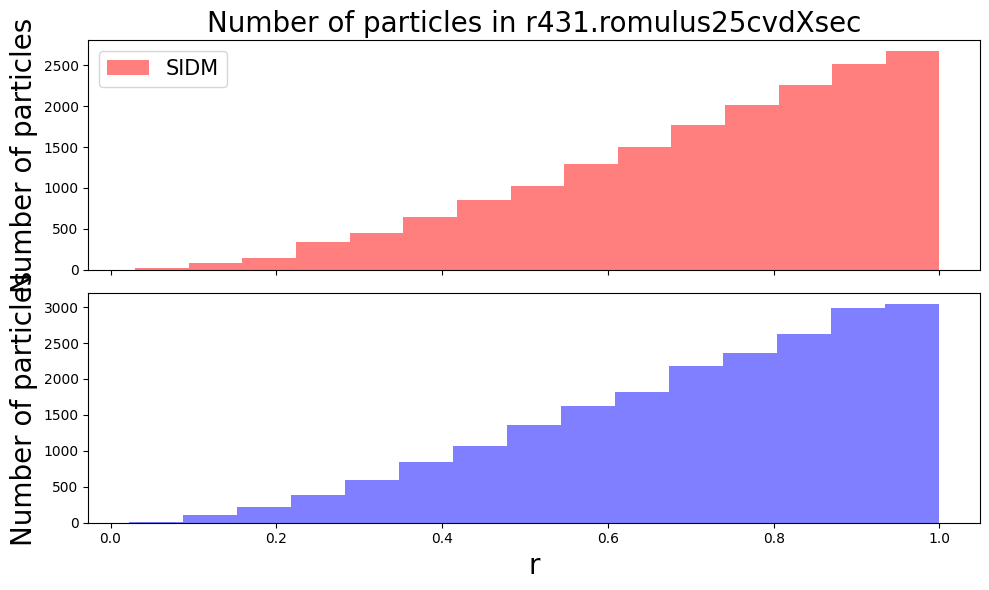

In [10]:
r_SIDM, sidm_ba, sidm_ca, n_SIDM, r_CDM, cdm_ba, cdm_ca, n_CDM = measure_and_plot_shapes(HSIDM, HCDM,'r431.romulus25cvdXsec', rin = .01,rout = 1)


In [11]:
# print(r_CDM, cdm_ba, cdm_ca, cdm_ba-cdm_ca)
# print(r_SIDM, sidm_ba, sidm_ca, sidm_ba-sidm_ca)
print(n_SIDM, n_CDM)


[420 518 499 476 477   0 578 501   0 482 464 543 442 533 460 499 477 476
 428 476 452   0 467 476 377 461 483 418 509 447 524 470 501 534 549] [542 609 587 584 557 606 624 595 594 562 533 550 623 550 626 596 571 558
 574 553   0 642 537 546 626 560 569 604   0 599   0 612 604 614 662]


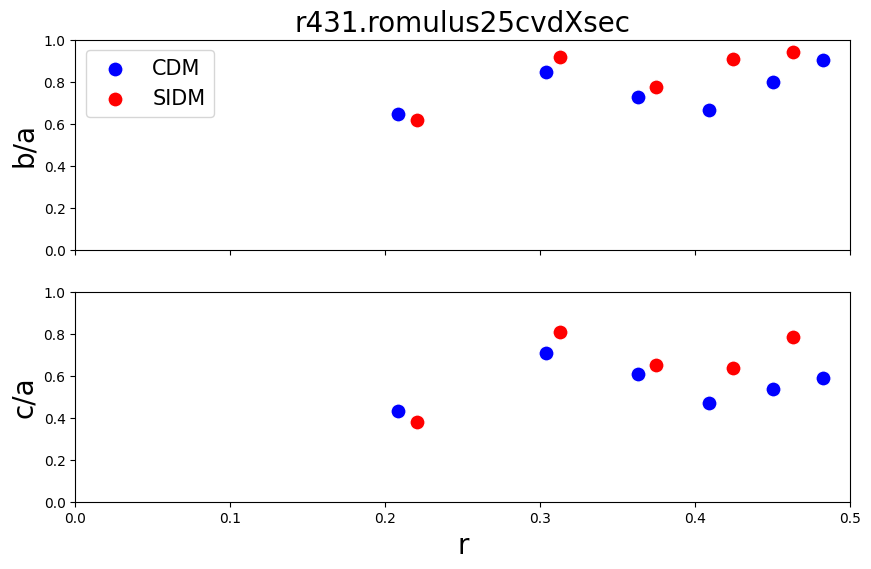

In [12]:
plotting(r_CDM, cdm_ba, cdm_ca, r_SIDM, sidm_ba, sidm_ca, 'r431.romulus25cvdXsec') #bin_size=0.05)

In [35]:
#define a function to loop through all SIDM sims, find the matching CDM sim and measure the shape

import pickle
def extract_number(sim_name):
    return sim_name.split('.')[0][1:]

def main(SIDMSims, CDMSims):

    #only process r634 for now
    #SIDMSims = {"r634.romulus25si2s50v35": {'path': '/data/akaxia/rzooms/r634.romulus25si2s50v35.3072g1HsbBH/r634.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]},}

    for SIDMname in SIDMSims:
        #load the SIDM sim
        SIDMsim = pynbody.load(SIDMSims[SIDMname]['path'])
        #load the CDM sim with name that starts with the same number after the r
        CDMname = 'r' + extract_number(SIDMname)
        print(SIDMname, CDMname)
        CDMSim = pynbody.load(CDMSims[CDMname]['path'])
        SIDMsim.physical_units()
        CDMSim.physical_units()
        #center the halos
        HCDM = CDMSim.halos()[1]
        HSIDM = SIDMsim.halos()[1]

        pynbody.analysis.halo.center(HCDM, mode='hyb')
        pynbody.analysis.halo.center(HSIDM, mode='hyb')

        #measure and plot the shapes
        r_SIDM, sidm_ba, sidm_ca, n_SIDM, r_CDM, cdm_ba, cdm_ca, n_CDM = measure_and_plot_shapes(HSIDM, HCDM,SIDMname, rin = .01,rout = .5)
        #save the results as a pickle file
        plotting(r_CDM, cdm_ba, cdm_ca, r_SIDM, sidm_ba, sidm_ca, SIDMname)

        with open(f'../../Data/{SIDMname}_shapes.pkl', 'wb') as f:
            pickle.dump([r_SIDM, sidm_ba, sidm_ca,n_SIDM, r_CDM, cdm_ba, cdm_ca, n_CDM], f)


def plot(SIDMSims):
    for SIDMname in SIDMSims:
        print(SIDMname)
        #load pickled data

        with open(f'../../Data/{SIDMname}_shapes.pkl', 'rb') as f:
            r_SIDM, sidm_ba, sidm_ca,n_SIDM, r_CDM, cdm_ba, cdm_ca, n_CDM = pickle.load(f)
        print(n_SIDM, n_CDM)
        #plot the shapes
                #plot the shapes
        plotting(r_SIDM, sidm_ba, sidm_ca,n_SIDM, r_CDM, cdm_ba, cdm_ca, n_CDM, SIDMname)
        #break





In [26]:


main(SIDMSims, CDMSims)
    

r634.romulus25si2s50v35 r634


KeyboardInterrupt: 

r634.romulus25si2s50v35
[617] [2393]
r492.romulus25si2s50v35
[256 545] [1088 1054]
r468.romulus25si2s50v35
[367 435 562 532] [1213 1227 1306 1290]
r488.romulus25si2s50v35
[358 658] [ 923 1096]
r544.romulus25si2s50v35
[527] [1464]
r597.romulus25si2s50v35
[441 419] [488 555]
r523.romulus25si2s50v35
[188] [890]
r618.romulus25si2s50v35
[533 556 464] [629 869 886]
r431.romulus25cvdXsec
[457 572 532 548 572] [641 727 698 703 734]
r492.romulus25cvdXsec
[524 569 592] [667 727 753]


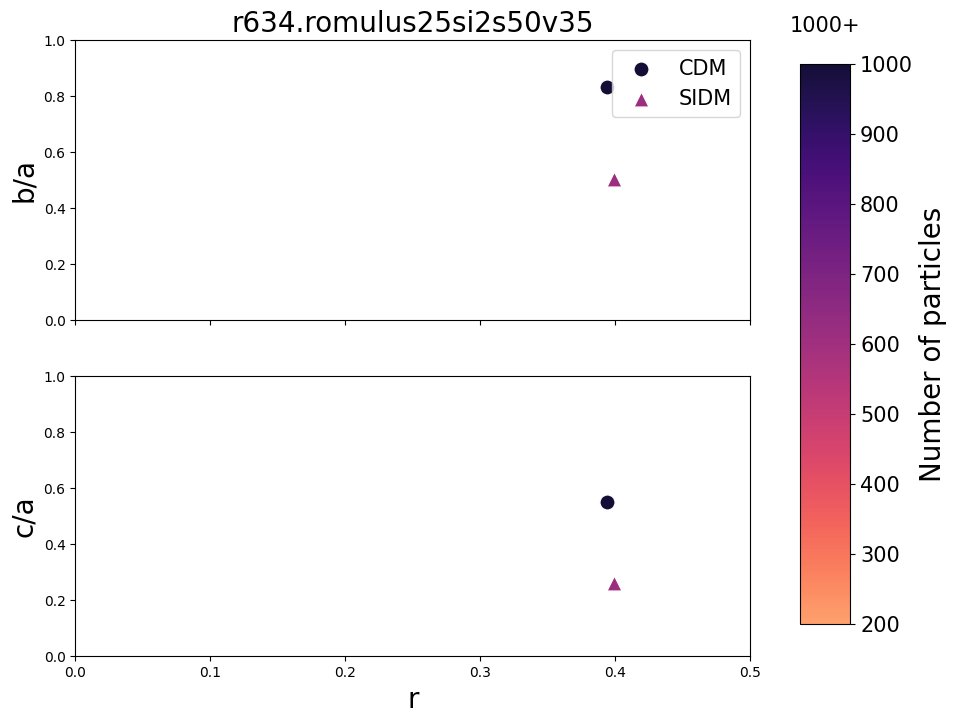

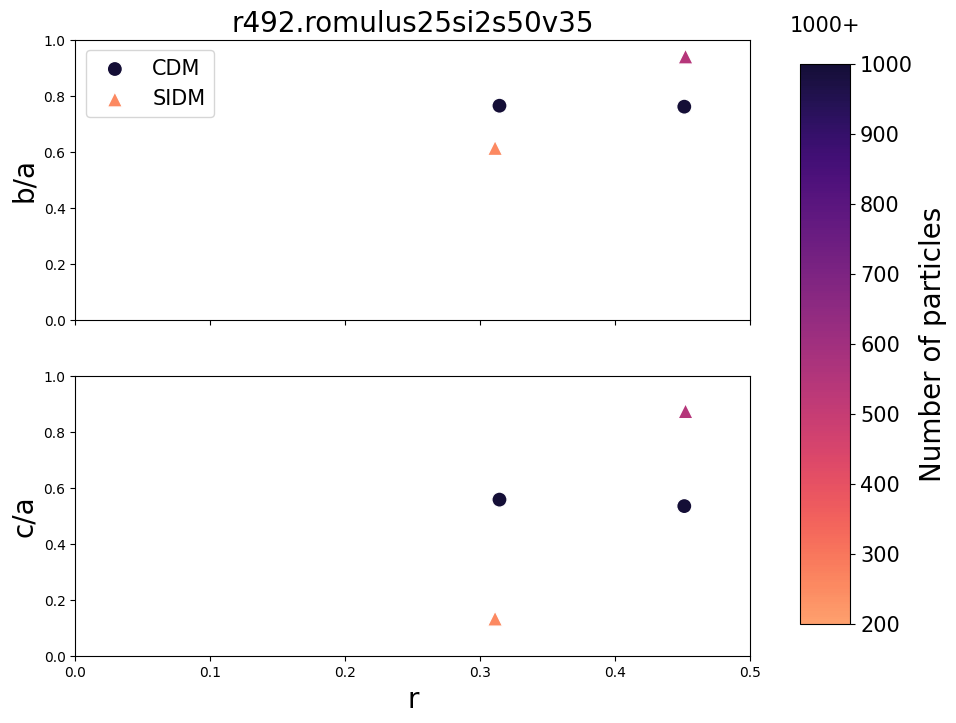

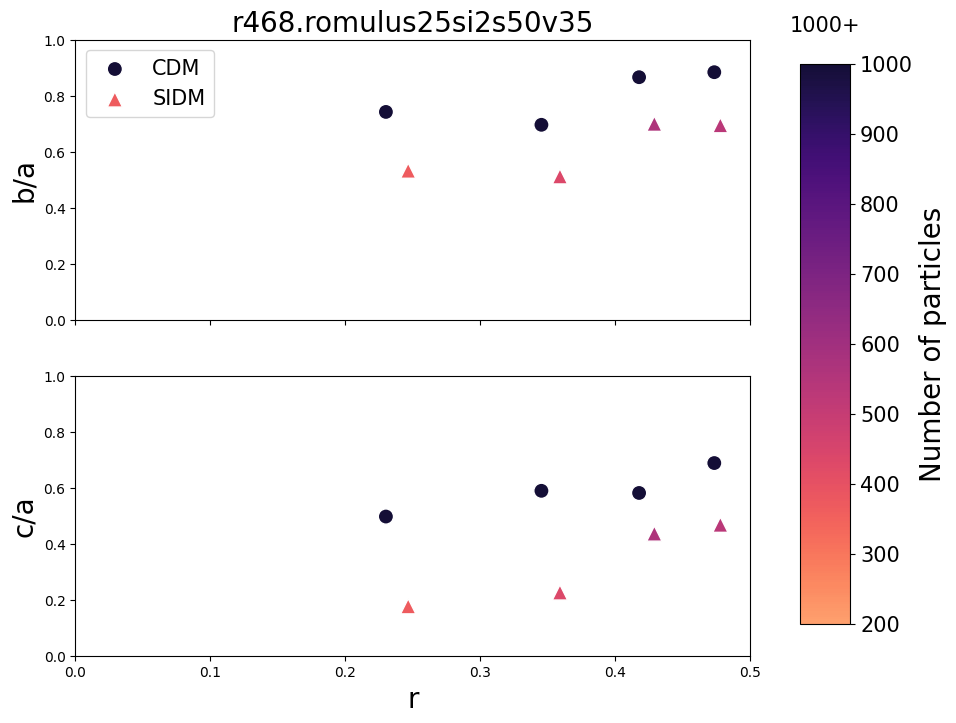

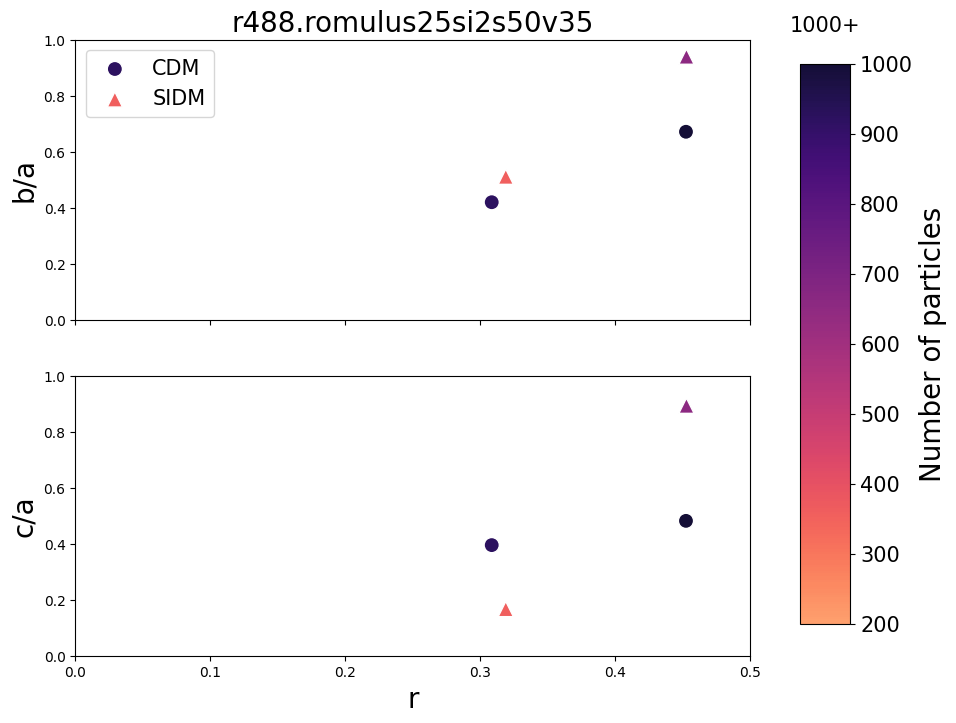

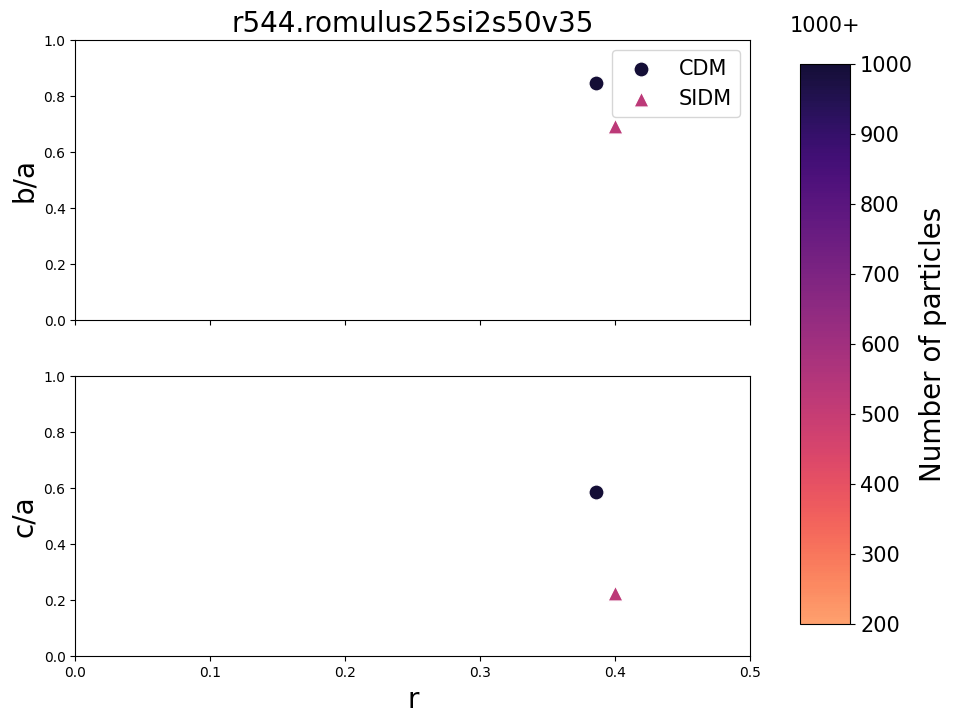

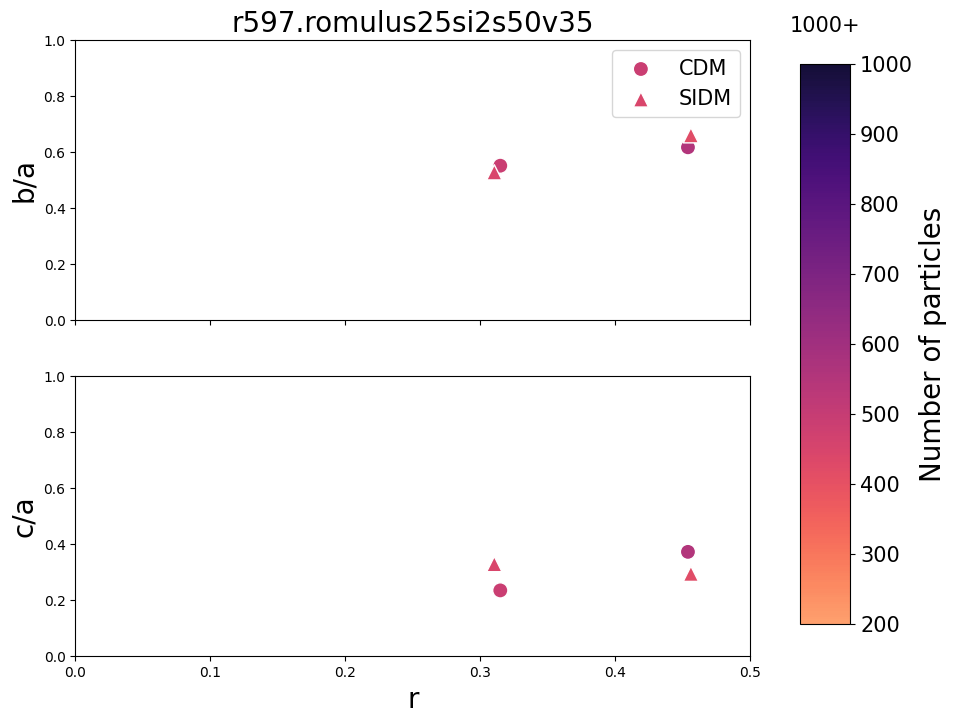

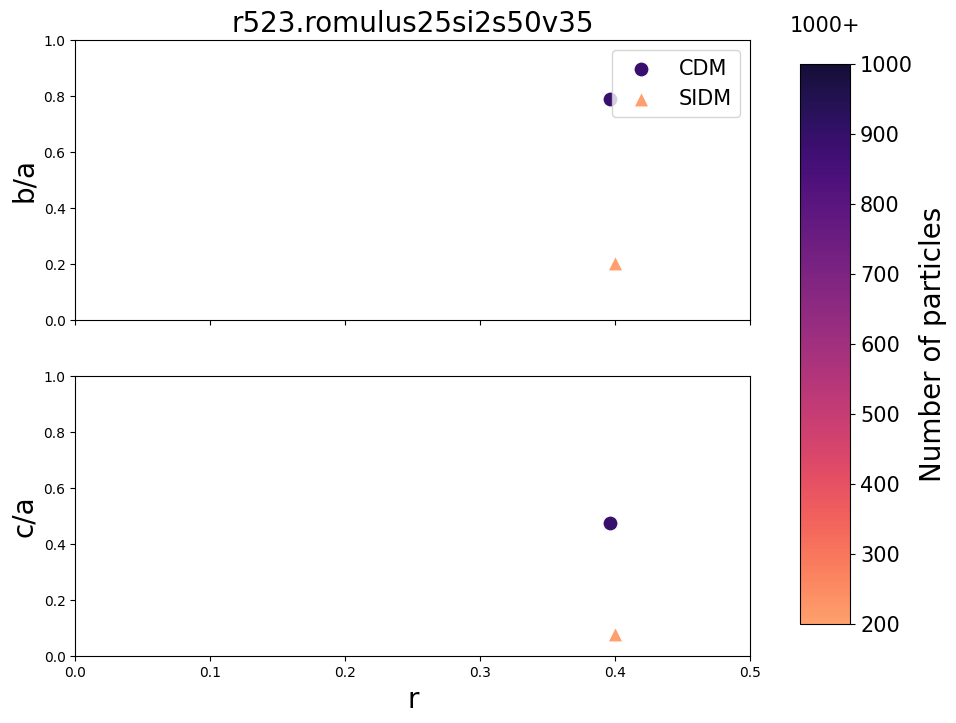

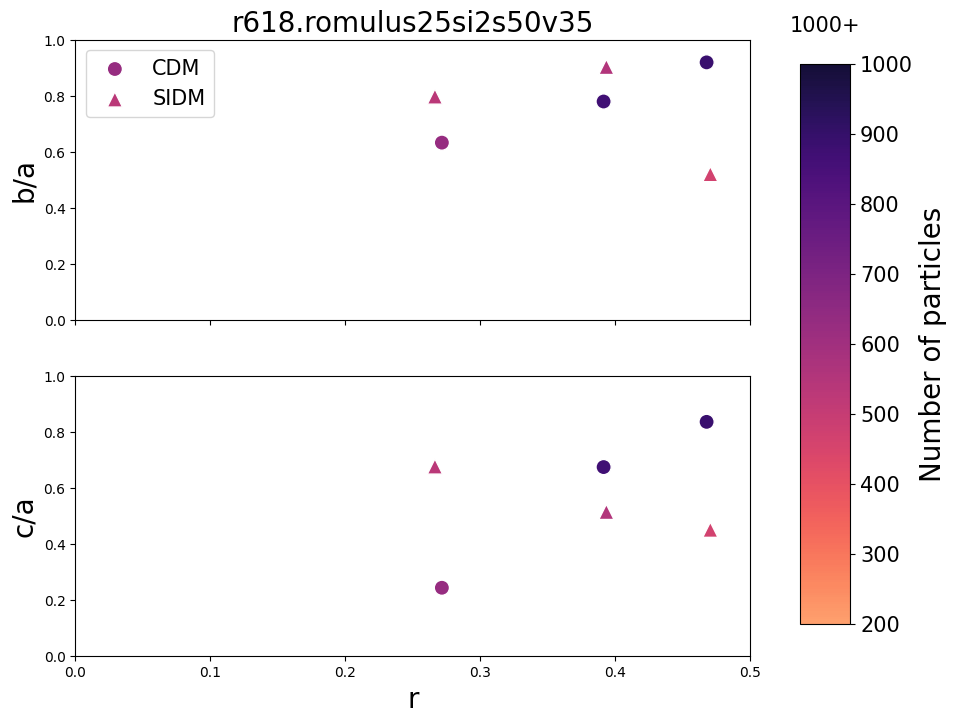

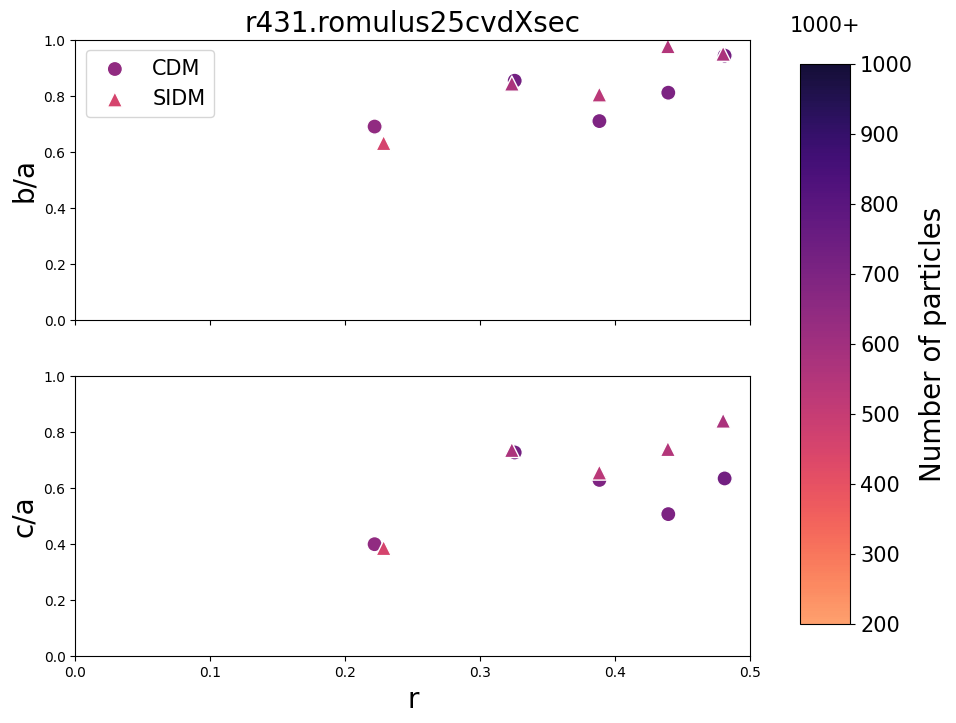

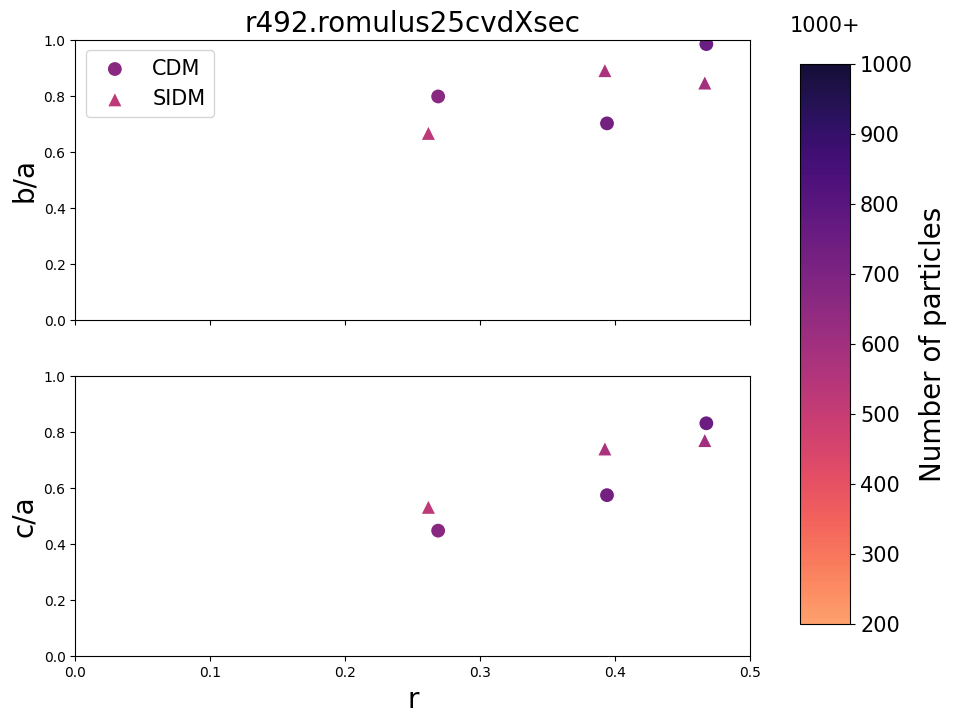

In [54]:
plot(SIDMSims)

In [12]:
import pynbody
import os
import pickle
import sys

path = '/home/bk639/MorphologyMeasurements/Code'
sys.path.append(path)
#print(sys.path)

# Import the SimInfoDicts package
from SimInfoDicts.sim_type_name import sim_type_name
for feedback, use_sim in sim_type_name.items():
    for t in ['3DShapes','DMShapes']:
        #if feedback=='BWMDC':
            #continue
        if use_sim:
            
            pickle_path = f'../PickleFiles/SimulationInfo.{feedback}.pickle'
            if os.path.exists(pickle_path):
                SimInfo = pickle.load(open(pickle_path, 'rb'))
                #load sims
                for sim in SimInfo:
                    
                    s = pynbody.load(SimInfo[sim]['path'])
                    s.physical_units()
                    #load halos
                    halos = s.halos()
                    #print(halos,len(halos))
                    #check which halos have at least 5000 star 
                    good_halos = []
                    for i in range(100):
                        try:
                            halo = halos[i]
                            if len(halo.s) > 5000:
                                good_halos.append(i)
                                #print(halo.properties)
                                break
                        except:
                            continue
                    print(f'sim: {feedback}, good halos: {good_halos}')

sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: BWMDC, good halos: [0]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [0]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [0]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: MerianCDM, good halos: [1]
sim: Mer

pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/pynbody/halo/ahf.py:157: UserWarning: Unable to write AHF_fpos file; performance will be reduced. Pass write_fpos=False to halo constructor to suppress this message.
  warnings.warn("Unable to write AHF_fpos file; performance will be reduced. Pass write_fpos=False to halo constructor to suppress this message.")


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]
sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]
sim: MerianSIDM, good halos: [1]


pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


sim: MerianSIDM, good halos: [1]
sim: MerianSIDM, good halos: [1]
